# DS 542 Fall 2025 Project 3

Your task for this project is to train an attention-based decoder-only model for math expressions with positive integers, addition, and parenthesis.
A sample model is provided and demonstrated on small problems with single digit integer inputs.
Your goal is to scale up this model to handle two digit inputs and longer expressions.

## Problem Setup

In [1]:
import math
import random

import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
characters = "()+0123456789="
TOKENS = ["<bos>", "<eos>", "<pad>"] + [c for c in characters]
print(TOKENS)

['<bos>', '<eos>', '<pad>', '(', ')', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=']


In [4]:
TOKEN_MAP = dict((t, i) for i, t in enumerate(TOKENS))
print(TOKEN_MAP)

{'<bos>': 0, '<eos>': 1, '<pad>': 2, '(': 3, ')': 4, '+': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '=': 16}


In [5]:
BOS = TOKEN_MAP["<bos>"]
EOS = TOKEN_MAP["<eos>"]
PAD = TOKEN_MAP["<pad>"]

In [6]:
def decode(token_ids):
    return "".join(TOKENS[i] for i in token_ids)

decode([0, 3, 7, 5, 6, 4, 1, 2])

'<bos>(1+0)<eos><pad>'

In [7]:
def encode(s, *, eos=True):
    if s.startswith("<bos>"):
        s = s[5:]

    output = [BOS]
    output.extend(TOKEN_MAP[c] for c in s)

    if eos:
        output.append(EOS)

    return torch.tensor(output, device=device)

decode(encode("1+2=3"))

'<bos>1+2=3<eos>'

### Problem Generation

This function `generate_instance` will generate a random expression starting from `n` random integers between `value_min` and `value_max` (inclusive) and combining them with addition in a random order.
The full expression consists of multiple rounds of reductions of the innermost parentheses replacing the parenthesized addition with its integer value.
The final value after the last equals sign is the value of the original expression before the first equals sign.

Here are some example expressions.

* `(3+4)+(9+2)=(7+11)=18`
* `(((((1+2)+3)+4)+5)+6)=((((3+3)+4)+5)+6)=(((6+4)+5)+6)=((10+5)+6)=(15+6)=21`

To be clear, each reduction step should replace all the parenthesis that only contain two numbers being added.


In [8]:
# DO NOT CHANGE

def generate_instance(n, *, value_min=1, value_max=9):
    current_numbers = [random.randint(value_min, value_max) for _ in range(n)]
    current_expressions = [[str(v) for v in current_numbers]]
    current_fresh = [True for _ in current_numbers]

    while len(current_numbers) > 1:
        next_numbers = []
        next_expressions = [[] for _ in range(len(current_expressions) + 1)]
        next_fresh = []

        i = 0
        while i < len(current_numbers):
            can_merge = (i + 1 < len(current_numbers)) and (current_fresh[i] or current_fresh[i + 1])
            if can_merge and random.random() < 0.5:
                # decided to merge
                next_numbers.append(current_numbers[i] + current_numbers[i + 1])

                next_expressions[0].append(str(next_numbers[-1]))
                for j in range(len(current_expressions)):
                    next_expressions[j + 1].append(f"({current_expressions[j][i]}+{current_expressions[j][i + 1]})")

                next_fresh.append(True)
                i += 2
            else:
                # decided not to merge
                next_numbers.append(current_numbers[i])

                next_expressions[0].append(str(next_numbers[-1]))
                for j in range(len(current_expressions)):
                    next_expressions[j + 1].append(current_expressions[j][i])

                next_fresh.append(False)
                i += 1

        if len(next_numbers) < len(current_numbers):
            current_numbers = next_numbers
            current_expressions = next_expressions
            current_fresh = next_fresh

    output = '='.join(e[0] for e in reversed(current_expressions))
    return encode(output)

decode(generate_instance(3))

'<bos>((8+5)+9)=(13+9)=22<eos>'

In [9]:
for i in range(10):
    print(decode(generate_instance(5)))

<bos>((2+((1+1)+6))+2)=((2+(2+6))+2)=((2+8)+2)=(10+2)=12<eos>
<bos>(2+(((4+1)+7)+5))=(2+((5+7)+5))=(2+(12+5))=(2+17)=19<eos>
<bos>(5+((1+7)+(3+3)))=(5+(8+6))=(5+14)=19<eos>
<bos>((((6+3)+8)+9)+8)=(((9+8)+9)+8)=((17+9)+8)=(26+8)=34<eos>
<bos>((5+(9+(8+9)))+5)=((5+(9+17))+5)=((5+26)+5)=(31+5)=36<eos>
<bos>(((1+4)+9)+(5+1))=((5+9)+6)=(14+6)=20<eos>
<bos>((((9+5)+7)+7)+5)=(((14+7)+7)+5)=((21+7)+5)=(28+5)=33<eos>
<bos>(((4+4)+6)+(9+7))=((8+6)+16)=(14+16)=30<eos>
<bos>(((6+8)+(5+7))+8)=((14+12)+8)=(26+8)=34<eos>
<bos>(((7+3)+4)+(7+6))=((10+4)+13)=(14+13)=27<eos>


## Implement a model that generalizes to more numbers and larger numbers


The sample code that follows is based on this ChatGPT session.

https://chatgpt.com/share/69036c83-171c-800c-9216-0884476017c6

In [10]:
def make_batch(*args, batch_size=64, **kwargs):
    seqs = [generate_instance(*args, **kwargs) for _ in range(batch_size)]

    # pad to max length on right
    batch = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=PAD)

    # next token targets: inputs are all but last; targets are all but first
    x = batch[:, :-1]
    y = batch[:, 1:]

    return x.to(device), y.to(device)

make_batch(5)

(tensor([[ 0,  3, 14,  ...,  8, 12,  1],
         [ 0,  3,  3,  ...,  2,  2,  2],
         [ 0,  3,  3,  ..., 16,  9,  8],
         ...,
         [ 0,  3,  3,  ...,  2,  2,  2],
         [ 0,  3,  3,  ...,  2,  2,  2],
         [ 0,  3,  3,  ..., 16,  8,  7]], device='cuda:0'),
 tensor([[ 3, 14,  5,  ..., 12,  1,  2],
         [ 3,  3, 14,  ...,  2,  2,  2],
         [ 3,  3,  3,  ...,  9,  8,  1],
         ...,
         [ 3,  3,  3,  ...,  2,  2,  2],
         [ 3,  3, 12,  ...,  2,  2,  2],
         [ 3,  3,  7,  ...,  8,  7,  1]], device='cuda:0'))

In [11]:
def causal_mask(T):
    # shape (T, T); True = mask (disallow), False = keep
    # nn.Transformer expects float mask or bool depending on API;
    # TransformerEncoder uses src_mask where non-zero entries are masked.
    # We'll use a float mask with -inf above diagonal.
    m = torch.full((T, T), float("-inf"), device=device)
    m = torch.triu(m, diagonal=1)  # upper triangle is masked
    return m

In [12]:
# YOUR CHANGES HERE

class MathTransformer(torch.nn.Module):
    def __init__(self, d_model=256, nhead=4, num_layers=4, dim_ff=512, max_len=1024, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        vocab_size = len(TOKENS)

        # token + position embeddings
        self.tok_emb = torch.nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos_emb = torch.nn.Embedding(max_len, d_model)

        self.blocks = torch.nn.ModuleList([
            torch.nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_ff,
                dropout=dropout,
                batch_first=True,
                activation='gelu',
                norm_first=True,   
            )
            for _ in range(num_layers)
        ])
        
        self.lm_head = torch.nn.Linear(d_model, vocab_size)

        # init
        torch.nn.init.normal_(self.tok_emb.weight, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.pos_emb.weight, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.lm_head.weight, mean=0.0, std=0.02)
        torch.nn.init.zeros_(self.lm_head.bias)

    def forward(self, x):
        # x: (N, T)
        N, T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0)  # (1, T)
        h = self.tok_emb(x) * math.sqrt(self.d_model) + self.pos_emb(pos)  # (N, T, d_model)

        # key padding mask: True where we want to ignore (PAD)
        key_padding_mask = (x == PAD)  # (N, T) bool

        # causal mask for self-attention (float, -inf above diagonal)
        attn_mask = causal_mask(T).to(x.device) # (T, T)

        for layer in self.blocks:
            h = layer(
                h,
                src_mask=attn_mask,                         # causal
                src_key_padding_mask=key_padding_mask   # pad masking
            )
        logits = self.lm_head(h)  # (N, T, vocab)
        return logits

    @torch.no_grad()
    def generate(self, prefix_ids, max_new_tokens=400):
        self.eval()
        x = prefix_ids.clone().to(next(self.parameters()).device)  # (N, T0)

        max_total_len = self.max_len
        for _ in range(max_new_tokens):
            if x.size(1) >= max_total_len:
                print(x.size(1), "BREAK BECAUSE REACH LIMIT LENGTH")
                break
            logits = self.forward(x)[:, -1, :]   # (N, V)
            next_id = torch.argmax(logits, dim=-1, keepdim=True)  # greedy
            x = torch.cat([x, next_id], dim=1)
            if (next_id == EOS).all():
                break
        return x



test_model = MathTransformer(d_model=8, nhead=2, num_layers=2, dim_ff=2, max_len=64, dropout=0.1)


In [13]:
# model = MathTransformer().to(device)
# criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4) 

# model.train()
# steps = 800
# for step in range(1, steps+1):
#     x, y = make_batch(3, batch_size=1024)  # x,y: (N, T)
#     logits = model(x)                  # (N, T, V)
#     loss = criterion(logits.reshape(-1, len(TOKENS)), y.reshape(-1))
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()
#     optimizer.step()
#     if step % 100 == 0:
#         print(f"step {step:4d} | loss {loss.item():.4f}")




In [26]:
def get_value_min_max(n):
    if n <= 0:
        raise ValueError("incorrect format of n")
    value_min = 10**(n-1)
    value_max = 10**n - 1
    return value_min, value_max

def generate_range(k, n): 
    ranges = [] 
    for digits in range(k, n+1):
        val_min, val_max = get_value_min_max(digits) 
        ranges.append((val_min, val_max)) 
    return ranges


def pad_to(tensor, length, pad_value=PAD):
    N, T = tensor.shape
    if T < length:
        pad = torch.full((N, length - T), pad_value, device=tensor.device, dtype=tensor.dtype)
        return torch.cat([tensor, pad], dim=1)
    return tensor 

def generate_dataset(): 
    ns = [2,3,4,5]
    ranges = generate_range(1, 3) 
    
    X_list = [] 
    y_list = [] 
    max_len = 0 

    for n in ns:    
        if n == 5: 
            for (value_min, value_max) in ranges: 
                x, y = make_batch(n=n, value_min=value_min, value_max=value_max, batch_size=10240)  # x,y: (N, T) 
                max_len = max(x.size(1), max_len) 
                X_list.append(x)
                y_list.append(y) 
            for (value_min, value_max) in ranges[-2:]: 
                x, y = make_batch(n=n, value_min=value_min, value_max=value_max, batch_size=10240)  # x,y: (N, T) 
                max_len = max(x.size(1), max_len) 
                X_list.append(x)
                y_list.append(y) 
        if n == 4: 
            for (value_min, value_max) in ranges[-2:]: 
                x, y = make_batch(n=n, value_min=value_min, value_max=value_max, batch_size=10240)  # x,y: (N, T) 
                max_len = max(x.size(1), max_len) 
                X_list.append(x)
                y_list.append(y)
        
            
        for (value_min, value_max) in ranges: 
            x, y = make_batch(n=n, value_min=value_min, value_max=value_max, batch_size=10240)  # x,y: (N, T) 
            max_len = max(x.size(1), max_len) 
            X_list.append(x)
            y_list.append(y) 
    
    
    X_padded = [pad_to(x, max_len) for x in X_list]
    y_padded = [pad_to(y, max_len) for y in y_list]
    
    X_combined = torch.cat(X_padded, dim=0)
    y_combined = torch.cat(y_padded, dim=0)

    return X_combined, y_combined


In [15]:
import copy
from torch.utils.data import TensorDataset, DataLoader 
import numpy as np 
import matplotlib.pyplot as plt

In [27]:

def train_eval(epochs=1000, patience=200, learning_rate=3e-4, early_stopping = True, weight_decay_lamb=0.0, model_name="math_model"): 

    
    model = MathTransformer().to(device)

     
    # setup the optimizer and criterion 
    criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_lamb) 

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    scaler = torch.cuda.amp.GradScaler()

    train_losses, val_losses = [], [] 
    train_accuracies, val_accuracies = [], [] 
    gradients = [] 
    
    best_val_loss = float('inf') 
    best_epoch = -1 
    best_model_state = None 
    best_model_performance = None 
    
    epochs_no_improve = 0 
  
    vocab_size = len(TOKENS)


    def train(dataset_X, dataset_y, val_dataset_X, val_dataset_y, start_epoch, end_epoch): 
        nonlocal best_val_loss, best_epoch, best_model_state, best_model_performance, epochs_no_improve
        for epoch in range(start_epoch, end_epoch+1):
            model.train()
            train_loss = 0.0
            batch_count = 0
            train_correct = 0 
            total_tokens = 0 
        
            idx = torch.randint(0, dataset_X.size(0), (10240,))
            X = dataset_X[idx]
            y = dataset_y[idx]
            
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda"):
                logits = model(X)  # expect (N, T, V)
                loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
    
            scaler.scale(loss).backward()
            for p in model.parameters():
                if p.grad is not None:
                    p.grad.data = torch.clamp(p.grad.data, -1.0, 1.0)
            scaler.step(optimizer)
            scaler.update()
    
            train_loss += loss.item() 
            pred = torch.argmax(logits, dim=-1)
            train_correct += (pred.reshape(-1) == y.reshape(-1)).sum().item()
            total_tokens += y.numel()
            batch_count += 1
    
            scheduler.step()
            train_loss = train_loss / max(1, batch_count)
            # train_accuracy = train_correct / total_tokens
            train_losses.append(train_loss)
            # train_accuracies.append(train_accuracy) 
        
            # Evaluate
            model.eval()
            val_loss = 0.0
            val_batch_count = 0
            val_correct = 0
            total_val_tokens = 0 
            with torch.no_grad():
                idx = torch.randint(0, val_dataset_X.size(0), (10240,))
                X = val_dataset_X[idx]
                y = val_dataset_y[idx]
                
                        
                logits = model(X)
                loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
                val_loss += loss.item()
                val_pred = torch.argmax(logits, dim=-1)
                val_correct += (val_pred.reshape(-1) == y.reshape(-1)).sum().item()
                total_val_tokens += y.numel() 
                val_batch_count += 1
        
            val_loss = val_loss / max(1, val_batch_count)
            # val_accuracy = val_correct / total_val_tokens
            val_losses.append(val_loss)        
            # val_accuracies.append(val_accuracy) 
        
            grads = [] 
            for _, p in model.named_parameters(): 
                if p.grad is not None: 
                    grads.append(p.grad.abs().mean().item()) 
            gradients.append(np.mean(grads)) 
    
            
            # Early Stopping 
            if early_stopping: 
                if val_loss < best_val_loss:
                    best_val_loss = val_loss 
                    best_epoch = epoch
                    best_model_state = copy.deepcopy(model.state_dict()) 
                    best_model_performance = {
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        # 'train_accuracy': train_accuracy,
                        # 'val_accuracy': val_accuracy
                    }
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
        
                if epochs_no_improve >= patience:
                    print(f"Stopped training beacuse model did not improve for {patience} epochs")
                    break 
            else:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch
                    best_model_state = copy.deepcopy(model.state_dict())
    
            
                
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}") 
        
                
    
        
    dataset_X, dataset_y = generate_dataset()   
    val_dataset_X, val_dataset_y = generate_dataset()  
    train(dataset_X, dataset_y, val_dataset_X, val_dataset_y, 1, epochs)
    




    if best_model_performance is not None:
        print(f"Performance of final model- train_loss: {best_model_performance['train_loss']:.4f}, val_loss: {best_model_performance['val_loss']:.4f}")
    else: 
        print(f"Performance of final model - train_loss: {train_losses[-1]:.4f}, val_loss: {val_losses[-1]:.4f}")

    if early_stopping and best_model_state is not None:
        model.load_state_dict(best_model_state) 
        print(f"Loaded best model from epoch {best_epoch + 1}") 
        
    torch.save(model.state_dict(), model_name + ".pt") 
    print(f"Model saved to {model_name}.pt") 

    # Plot the charts 
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    if early_stopping:
        plt.axvline(best_epoch, linestyle='--', color='r', label='Early Stop Epoch')
    plt.title("Loss during training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend() 

    # plt.subplot(1,3,2)
    # plt.plot(train_accuracies, label="Train Accuracy")
    # plt.plot(val_accuracies, label="Val Accuracy")
    # if early_stopping:
    #     plt.axvline(best_epoch, linestyle='--', color='r', label='Early Stop Epoch')
    # plt.title("Accuracy during training")
    # plt.xlabel("Epochs")
    # plt.ylabel("Accuracy")
    # plt.legend() 

    plt.subplot(1,3,3)
    plt.plot(gradients) 
    plt.title("Average Gradient of Each Epoch") 
    plt.xlabel("Epoch") 

    plt.suptitle(f"Training: EarlyStop={early_stopping}, LearningRate = {learning_rate}")
    plt.show() 

    
    return model, train_losses, val_losses, train_accuracies, val_accuracies, gradients 


/scratch/1646204.1.l40s/ipykernel_2930249/3712837921.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 101/4000 - train_loss: 1.8380, val_loss: 1.7925
Epoch 201/4000 - train_loss: 1.8267, val_loss: 1.6743
Epoch 301/4000 - train_loss: 1.5345, val_loss: 1.7902
Epoch 401/4000 - train_loss: 1.3984, val_loss: 1.2912
Epoch 501/4000 - train_loss: 1.5100, val_loss: 1.3700
Epoch 601/4000 - train_loss: 1.4649, val_loss: 1.4122
Epoch 701/4000 - train_loss: 1.1098, val_loss: 1.0025
Epoch 801/4000 - train_loss: 0.9938, val_loss: 0.9186
Epoch 901/4000 - train_loss: 1.0092, val_loss: 0.8842
Epoch 1001/4000 - train_loss: 0.9177, val_loss: 0.8498
Epoch 1101/4000 - train_loss: 0.8955, val_loss: 0.8381
Epoch 1201/4000 - train_loss: 0.8083, val_loss: 0.7097
Epoch 1301/4000 - train_loss: 0.6922, val_loss: 0.6120
Epoch 1401/4000 - train_loss: 0.6486, val_loss: 0.5908
Epoch 1501/4000 - train_loss: 0.6466, val_loss: 0.6148
Epoch 1601/4000 - train_loss: 0.5838, val_loss: 0.5476
Epoch 1701/4000 - train_loss: 0.5722, val_loss: 0.5437
Epoch 1801/4000 - train_loss: 0.5781, val_loss: 0.5591
Epoch 1901/4000 - t

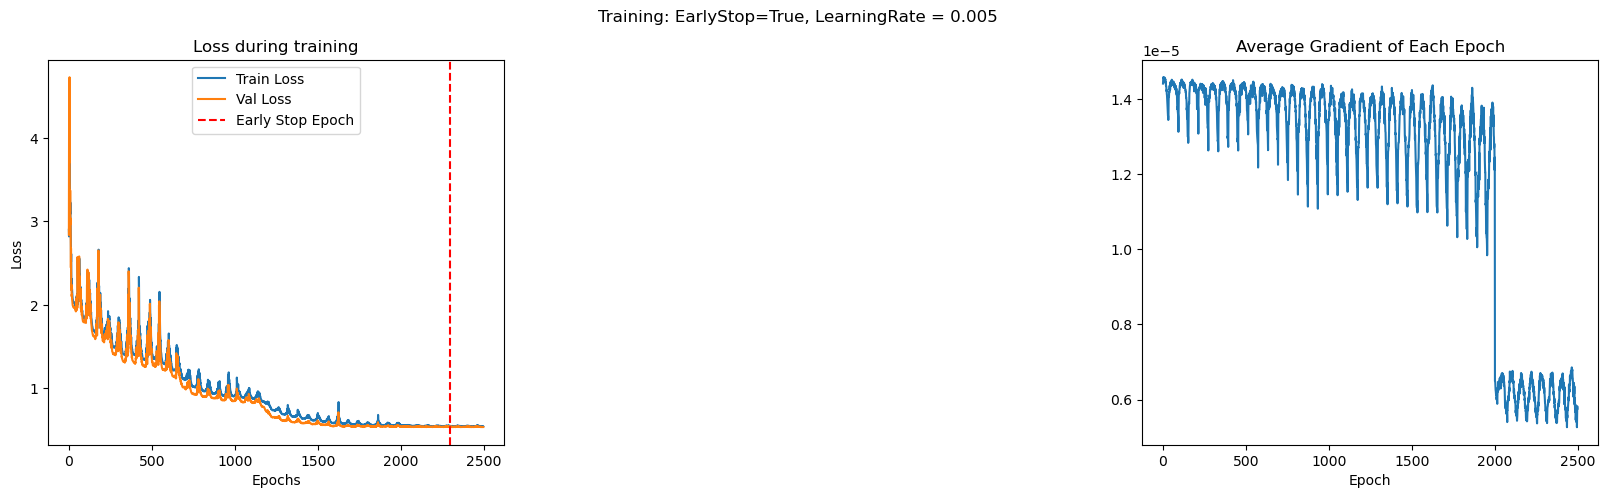

In [34]:
model, train_losses, val_losses, train_accuracies, val_accuracies, gradients = train_eval(epochs=4000, patience=200, learning_rate=5e-3)

/scratch/1651926.1.l40s/ipykernel_3197998/1975798575.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 101/5000 - train_loss: 1.8307, val_loss: 1.8040
Epoch 301/5000 - train_loss: 1.6194, val_loss: 1.4580
Epoch 401/5000 - train_loss: 1.3026, val_loss: 1.2061
Epoch 501/5000 - train_loss: 1.1188, val_loss: 1.0098
Epoch 601/5000 - train_loss: 1.1337, val_loss: 1.2051
Epoch 701/5000 - train_loss: 0.9260, val_loss: 0.8698
Epoch 801/5000 - train_loss: 0.8960, val_loss: 0.8464
Epoch 901/5000 - train_loss: 0.9514, val_loss: 0.8650
Epoch 1001/5000 - train_loss: 0.8466, val_loss: 0.8100
Epoch 1101/5000 - train_loss: 0.8432, val_loss: 0.8122
Epoch 1201/5000 - train_loss: 0.8732, val_loss: 0.8170
Epoch 1301/5000 - train_loss: 0.8221, val_loss: 0.7759
Epoch 1401/5000 - train_loss: 0.8026, val_loss: 0.7614
Epoch 1501/5000 - train_loss: 0.6857, val_loss: 0.6028
Epoch 1601/5000 - train_loss: 0.5999, val_loss: 0.5612
Epoch 1701/5000 - train_loss: 0.5780, val_loss: 0.5476
Epoch 1801/5000 - train_loss: 0.5840, val_loss: 0.5472
Epoch 1901/5000 - train_loss: 0.5564, val_loss: 0.5405
Epoch 2001/5000 - 

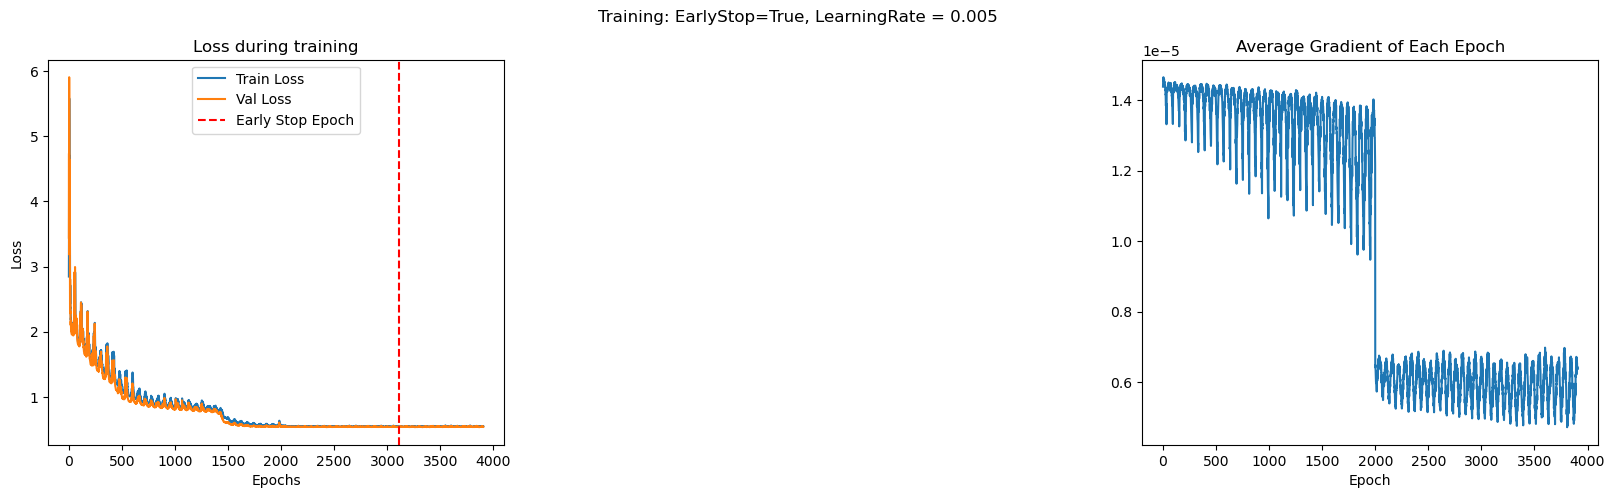

In [28]:
model, train_losses, val_losses, train_accuracies, val_accuracies, gradients = train_eval(epochs=5000, patience=800, learning_rate=5e-3)

In [18]:
def prepare_prompt(s):
    token_ids = encode(s)
    if '=' in s:
        token_ids = token_ids[:s.index('=')+2]
        assert token_ids[-1] == TOKEN_MAP['=']

    return torch.tensor([token_ids], dtype=torch.long, device=device)

In [19]:
decode(generate_instance(3))

'<bos>(8+(1+3))=(8+4)=12<eos>'

In [20]:
def test_example(*args, verbose=True, **kwargs):
    model.eval()

    target_token_ids = generate_instance(*args, **kwargs)
    target = decode(target_token_ids)

    prompt = target[:target.index('=')+1]
    prompt_token_ids = encode(prompt, eos=False)
    prompt_batch = prompt_token_ids.reshape(shape=(1,-1))

    actual_token_ids = model.generate(prompt_batch, max_new_tokens=25)[0]
    actual = decode(actual_token_ids)

    correct = actual == target

    if verbose or not correct:
        print("PROMPT", decode(prompt_token_ids), "TARGET", target, "ACTUAL", actual, "CORRECT", correct)

    return correct

test_example(n=3)

PROMPT <bos>(9+(7+5))= TARGET <bos>(9+(7+5))=(9+12)=21<eos> ACTUAL <bos>(9+(7+5))=(9+12)=21<eos> CORRECT True


True

In [21]:
for _ in range(10):
    test_example(n=3, verbose=True)

PROMPT <bos>((4+8)+6)= TARGET <bos>((4+8)+6)=(12+6)=18<eos> ACTUAL <bos>((4+8)+6)=(12+6)=18<eos> CORRECT True
PROMPT <bos>((1+8)+7)= TARGET <bos>((1+8)+7)=(9+7)=16<eos> ACTUAL <bos>((1+8)+7)=(9+7)=16<eos> CORRECT True
PROMPT <bos>((6+5)+1)= TARGET <bos>((6+5)+1)=(11+1)=12<eos> ACTUAL <bos>((6+5)+1)=(11+1)=12<eos> CORRECT True
PROMPT <bos>((6+2)+1)= TARGET <bos>((6+2)+1)=(8+1)=9<eos> ACTUAL <bos>((6+2)+1)=(8+1)=9<eos> CORRECT True
PROMPT <bos>(1+(7+7))= TARGET <bos>(1+(7+7))=(1+14)=15<eos> ACTUAL <bos>(1+(7+7))=(1+14)=15<eos> CORRECT True
PROMPT <bos>((1+2)+4)= TARGET <bos>((1+2)+4)=(3+4)=7<eos> ACTUAL <bos>((1+2)+4)=(3+4)=7<eos> CORRECT True
PROMPT <bos>(9+(1+6))= TARGET <bos>(9+(1+6))=(9+7)=16<eos> ACTUAL <bos>(9+(1+6))=(9+7)=16<eos> CORRECT True
PROMPT <bos>((9+7)+3)= TARGET <bos>((9+7)+3)=(16+3)=19<eos> ACTUAL <bos>((9+7)+3)=(16+3)=19<eos> CORRECT True
PROMPT <bos>((1+2)+2)= TARGET <bos>((1+2)+2)=(3+2)=5<eos> ACTUAL <bos>((1+2)+2)=(3+2)=5<eos> CORRECT True
PROMPT <bos>((7+2)+8)= TAR

In [22]:
for _ in range(10):
    test_example(n=4, verbose=False)

### Benchmark your model

Test your code with different numbers of integers and numbers of input digits.
The `generate_instance` function provided uses the parameter `n` to control the number of integers, and `value_min` and `value_max` to control the range of integers.
For example, 2 input digits would correspond to `value_min=10` and `value_max=99`.

Test the accuracy on the combinations specified in the table below, and fill in your accuracy numbers in that table.
Make sure that you run enough samples for statistical significance (usually at least 1000 recommended) as your benchmarking accuracy will be checked for consistency with tests by the auto-grader.

In [23]:
def test_example(*args, verbose=True, **kwargs):
    model.eval()

    target_token_ids = generate_instance(*args, **kwargs)
    target = decode(target_token_ids)

    prompt = target[:target.index('=')+1]
    prompt_token_ids = encode(prompt, eos=False)
    prompt_batch = prompt_token_ids.reshape(shape=(1,-1))

    actual_token_ids = model.generate(prompt_batch, max_new_tokens=100)[0]
    actual = decode(actual_token_ids)

    correct = actual == target

    # if verbose or not correct:
    #     print("PROMPT", decode(prompt_token_ids), "TARGET", target, "ACTUAL", actual, "CORRECT", correct)

    return correct

test_example(n=3)

True

In [24]:
# YOUR CHANGES HERE
def benchmark_model(n, value_min, value_max, num_samples=1000): 
    correct = 0
    for _ in range(num_samples):
        if test_example(n=n, value_min=value_min, value_max=value_max, verbose=False):
            correct += 1
    
    accuracy = correct / num_samples
    print(f'n = {n}，value_min={value_min}, value_max={value_max}: Accuracy = {accuracy}') 


In [29]:
for n in [2,3,4,5]: 
    for (value_min, value_max) in [(1,9), (10, 99), (100, 999)]: 
        benchmark_model(n, value_min, value_max, num_samples=1000) 

n = 2，value_min=1, value_max=9: Accuracy = 1.0
n = 2，value_min=10, value_max=99: Accuracy = 1.0
n = 2，value_min=100, value_max=999: Accuracy = 1.0
n = 3，value_min=1, value_max=9: Accuracy = 1.0
n = 3，value_min=10, value_max=99: Accuracy = 1.0
n = 3，value_min=100, value_max=999: Accuracy = 1.0
n = 4，value_min=1, value_max=9: Accuracy = 1.0
n = 4，value_min=10, value_max=99: Accuracy = 1.0
n = 4，value_min=100, value_max=999: Accuracy = 1.0
n = 5，value_min=1, value_max=9: Accuracy = 1.0
n = 5，value_min=10, value_max=99: Accuracy = 1.0
n = 5，value_min=100, value_max=999: Accuracy = 0.998


Fill in this table.

| n | input digits | accuracy |
|---|---|-----|
| 2 | 1 | 1 |
| 2 | 2 | 1 |
| 2 | 3 | 1 |
| 3 | 1 | 1 |
| 3 | 2 | 1 |
| 3 | 3 | 1 |
| 4 | 1 | 1 |
| 4 | 2 | 1 |
| 5 | 1 | 1 |
| 5 | 2 | 1 |

Do not change the table header as the auto-grader will use it to check your results.


In [51]:
model = MathTransformer().to(device)  # re-initialize the model architecture
model.load_state_dict(torch.load('math_model.pt'))

<All keys matched successfully>

In [43]:
for _ in range(3):
    test_example(n=5, value_min = 100, value_max = 999, verbose=True)

## Save model and implement a command line interface.

Your model will be tested automatically with a suite of examples with different numbers of values and digits matching your previous benchmark task.
For this testing, you must save your model weights and write a program to run your model.

### Save your model weights.

Save your model weights as `math.pt` to be submitted in Gradescope.

In [ ]:
# YOUR CHANGES HERE

# (it is already saved during the training process )

### Write a program to run your model.

Write a Python script `predict.py` that takes a single filename as input, reads each line as a prompt, generates the completion, and writes out the result to standard output.
We will invoke your program with a command like `python3 predict.py INPUT.txt` and capture the standard output for grading.

The input file will not include the special tokens such as `<bos>` or `<eos>`.
Similarly, your output should not include them either.

For example, given an input file with the following contents,
```
(((1+2)+1)+8)=
```
your program should write the following output.
```
(((1+2)+1)+8)=((3+1)+8)=(4+8)=12
```


## Final Submission

Submit your copy of this notebook with all your code, your saved model "best.py", and your prediction script "predict.py" to Gradescope.
